In [2]:
"""
Simple policy gradient in Keras
"""
import gym
import numpy as np

from keras import layers
from keras.models import Model
from keras import backend as K
from keras import utils as np_utils
from keras import optimizers

Using TensorFlow backend.


In [3]:
class Agent(object):

    def __init__(self, input_dim, output_dim, hidden_dims=[32, 32]):
        """Gym Playing Agent
        Args:
            input_dim (int): the dimension of state.
                Same as `env.observation_space.shape[0]`
            output_dim (int): the number of discrete actions
                Same as `env.action_space.n`
            hidden_dims (list): hidden dimensions
        Methods:
            private:
                __build_train_fn -> None
                    It creates a train function
                    It's similar to defining `train_op` in Tensorflow
                __build_network -> None
                    It create a base model
                    Its output is each action probability
            public:
                get_action(state) -> action
                fit(state, action, reward) -> None
        """

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.__build_network(input_dim, output_dim, hidden_dims)
        self.__build_train_fn()

    def __build_network(self, input_dim, output_dim, hidden_dims=[32, 32]):
        #instantiate the tensor
        self.X = layers.Input(shape=(input_dim,))
        net = self.X

        #Add all the hidden fully connected layers
        for h_dim in hidden_dims:
            net = layers.Dense(h_dim)(net)
            net = layers.Activation("relu")(net)

        #Match the output dimension
        net = layers.Dense(output_dim)(net)
        net = layers.Activation("softmax")(net)

        #Create the model
        self.model = Model(inputs=self.X, outputs=net)

    def __build_train_fn(self):
        """Create a train function
        It replaces `model.fit(X, y)` because we use the output of model and use it for training.
        For example, we need action placeholder
        called `action_one_hot` that stores, which action we took at state `s`.
        Hence, we can update the same action.
        This function will create
        `self.train_fn([state, action_one_hot, discount_reward])`
        which would train the model.
        """
        action_prob_placeholder = self.model.output
        action_onehot_placeholder = K.placeholder(shape=(None, self.output_dim),
                                                  name="action_onehot")
        discount_reward_placeholder = K.placeholder(shape=(None,),
                                                    name="discount_reward")

        action_prob = K.sum(action_prob_placeholder * action_onehot_placeholder, axis=1)
        log_action_prob = K.log(action_prob)

        loss = - log_action_prob * discount_reward_placeholder
        loss = K.mean(loss)

        adam = optimizers.Adam()

        updates = adam.get_updates(params=self.model.trainable_weights,
                                   #constraints=[],
                                   loss=loss)

        self.train_fn = K.function(inputs=[self.model.input,
                                           action_onehot_placeholder,
                                           discount_reward_placeholder],
                                   outputs=[],
                                   updates=updates)

    def get_action(self, state):
        """Returns an action at given `state`
        Args:
            state (1-D or 2-D Array): It can be either 1-D array of shape (state_dimension, )
                or 2-D array shape of (n_samples, state_dimension)
        Returns:
            action: an integer action value ranging from 0 to (n_actions - 1)
        """
        shape = state.shape

        if len(shape) == 1:
            assert shape == (self.input_dim,), "{} != {}".format(shape, self.input_dim)
            state = np.expand_dims(state, axis=0)

        elif len(shape) == 2:
            assert shape[1] == (self.input_dim), "{} != {}".format(shape, self.input_dim)

        else:
            raise TypeError("Wrong state shape is given: {}".format(state.shape))

        action_prob = np.squeeze(self.model.predict(state))
        assert len(action_prob) == self.output_dim, "{} != {}".format(len(action_prob), self.output_dim)
        return np.random.choice(np.arange(self.output_dim), p=action_prob)

    def fit(self, S, A, R):
        """Train a network
        Args:
            S (2-D Array): `state` array of shape (n_samples, state_dimension)
            A (1-D Array): `action` array of shape (n_samples,)
                It's simply a list of int that stores which actions the agent chose
            R (1-D Array): `reward` array of shape (n_samples,)
                A reward is given after each action.
        """
        action_onehot = np_utils.to_categorical(A, num_classes=self.output_dim)
        discount_reward = compute_discounted_R(R)

        assert S.shape[1] == self.input_dim, "{} != {}".format(S.shape[1], self.input_dim)
        assert action_onehot.shape[0] == S.shape[0], "{} != {}".format(action_onehot.shape[0], S.shape[0])
        assert action_onehot.shape[1] == self.output_dim, "{} != {}".format(action_onehot.shape[1], self.output_dim)
        assert len(discount_reward.shape) == 1, "{} != 1".format(len(discount_reward.shape))

        self.train_fn([S, action_onehot, discount_reward])


In [4]:
def compute_discounted_R(R, discount_rate=.99):
    """Returns discounted rewards
    Args:
        R (1-D array): a list of `reward` at each time step
        discount_rate (float): Will discount the future value by this rate
    Returns:
        discounted_r (1-D array): same shape as input `R`
            but the values are discounted
    Examples:
        >>> R = [1, 1, 1]
        >>> compute_discounted_R(R, .99) # before normalization
        [1 + 0.99 + 0.99**2, 1 + 0.99, 1]
    """
    discounted_r = np.zeros_like(R, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(R))):

        running_add = running_add * discount_rate + R[t]
        discounted_r[t] = running_add

    discounted_r -= discounted_r.mean() / discounted_r.std()

    return discounted_r

In [5]:
def run_episode(env, agent):
    """Returns an episode reward
    (1) Play until the game is done
    (2) The agent will choose an action according to the policy
    (3) When it's done, it will train from the game play
    Args:
        env (gym.env): Gym environment
        agent (Agent): Game Playing Agent
    Returns:
        total_reward (int): total reward earned during the whole episode
    """
    done = False
    S = []
    A = []
    R = []

    s = env.reset()

    total_reward = 0

    while not done:

        a = agent.get_action(s)

        #Execute the action and get the reward, add it to the total reward
        s2, r, done, info = env.step(a)
        total_reward += r

        S.append(s) #A 2-D array of each state, with 4 features - cart position, pole position, cart velocity and pole angle velocity
        A.append(a) #Stores which action the agent chooses (L or R)
        R.append(r) #Stores the reward associated (will always be 1 until we drop the pole)

        s = s2

        if done:
            S = np.array(S)
            A = np.array(A)
            R = np.array(R)

            agent.fit(S, A, R)
    
    return total_reward

In [15]:
#used matplotlib for all of the plotting
import matplotlib.pyplot as plt

#Used to save figures
from matplotlib.backends.backend_pdf import PdfPages

def plotResults(avgR):
    pp = PdfPages('Policy_Gradient_Plots.pdf')#creates pdf to save figures
    
    #Plots the accuracy of the agent for the training and testing data for each epoch
    plt.figure()
    plt.plot(avgR)
    plt.title("Model Results")
    plt.ylabel("Reward")
    plt.xlabel("Episode")
    plt.legend(['Average Reward'], loc='upper left')
    plt.savefig(pp, format='pdf')#appends the figure to the pdf

    pp.close()#closes the pdf and saves it

Episode: 1 Reward: 15.0 Average Reward:  15.0
Episode: 2 Reward: 24.0 Average Reward:  19.5
Episode: 3 Reward: 12.0 Average Reward:  17.0
Episode: 4 Reward: 19.0 Average Reward:  17.5
Episode: 5 Reward: 20.0 Average Reward:  18.0
Episode: 6 Reward: 19.0 Average Reward:  18.166666666666668
Episode: 7 Reward: 31.0 Average Reward:  20.0
Episode: 8 Reward: 34.0 Average Reward:  21.75
Episode: 9 Reward: 36.0 Average Reward:  23.333333333333332
Episode: 10 Reward: 13.0 Average Reward:  22.3
Episode: 11 Reward: 16.0 Average Reward:  21.727272727272727
Episode: 12 Reward: 15.0 Average Reward:  21.166666666666668
Episode: 13 Reward: 15.0 Average Reward:  20.692307692307693
Episode: 14 Reward: 22.0 Average Reward:  20.785714285714285
Episode: 15 Reward: 13.0 Average Reward:  20.266666666666666
Episode: 16 Reward: 14.0 Average Reward:  19.875
Episode: 17 Reward: 21.0 Average Reward:  19.941176470588236
Episode: 18 Reward: 22.0 Average Reward:  20.055555555555557
Episode: 19 Reward: 15.0 Average R

Episode: 150 Reward: 68.0 Average Reward:  23.833333333333332
Episode: 151 Reward: 28.0 Average Reward:  23.86092715231788
Episode: 152 Reward: 38.0 Average Reward:  23.95394736842105
Episode: 153 Reward: 12.0 Average Reward:  23.875816993464053
Episode: 154 Reward: 44.0 Average Reward:  24.006493506493506
Episode: 155 Reward: 17.0 Average Reward:  23.961290322580645
Episode: 156 Reward: 16.0 Average Reward:  23.91025641025641
Episode: 157 Reward: 22.0 Average Reward:  23.898089171974522
Episode: 158 Reward: 70.0 Average Reward:  24.189873417721518
Episode: 159 Reward: 30.0 Average Reward:  24.22641509433962
Episode: 160 Reward: 34.0 Average Reward:  24.2875
Episode: 161 Reward: 83.0 Average Reward:  24.652173913043477
Episode: 162 Reward: 18.0 Average Reward:  24.61111111111111
Episode: 163 Reward: 17.0 Average Reward:  24.56441717791411
Episode: 164 Reward: 17.0 Average Reward:  24.51829268292683
Episode: 165 Reward: 33.0 Average Reward:  24.56969696969697
Episode: 166 Reward: 20.0 A

Episode: 289 Reward: 72.0 Average Reward:  29.2560553633218
Episode: 290 Reward: 19.0 Average Reward:  29.220689655172414
Episode: 291 Reward: 19.0 Average Reward:  29.185567010309278
Episode: 292 Reward: 24.0 Average Reward:  29.16780821917808
Episode: 293 Reward: 35.0 Average Reward:  29.187713310580204
Episode: 294 Reward: 74.0 Average Reward:  29.34013605442177
Episode: 295 Reward: 58.0 Average Reward:  29.43728813559322
Episode: 296 Reward: 58.0 Average Reward:  29.533783783783782
Episode: 297 Reward: 17.0 Average Reward:  29.49158249158249
Episode: 298 Reward: 145.0 Average Reward:  29.879194630872483
Episode: 299 Reward: 64.0 Average Reward:  29.993311036789297
Episode: 300 Reward: 64.0 Average Reward:  30.106666666666666
Episode: 301 Reward: 73.0 Average Reward:  30.249169435215947
Episode: 302 Reward: 60.0 Average Reward:  30.3476821192053
Episode: 303 Reward: 51.0 Average Reward:  30.415841584158414
Episode: 304 Reward: 39.0 Average Reward:  30.44407894736842
Episode: 305 Rew

Episode: 423 Reward: 99.0 Average Reward:  42.319148936170215
Episode: 424 Reward: 49.0 Average Reward:  42.33490566037736
Episode: 425 Reward: 200.0 Average Reward:  42.705882352941174
Episode: 426 Reward: 200.0 Average Reward:  43.075117370892016
Episode: 427 Reward: 200.0 Average Reward:  43.442622950819676
Episode: 428 Reward: 137.0 Average Reward:  43.66121495327103
Episode: 429 Reward: 108.0 Average Reward:  43.81118881118881
Episode: 430 Reward: 88.0 Average Reward:  43.913953488372094
Episode: 431 Reward: 101.0 Average Reward:  44.046403712296986
Episode: 432 Reward: 139.0 Average Reward:  44.2662037037037
Episode: 433 Reward: 87.0 Average Reward:  44.364896073903004
Episode: 434 Reward: 103.0 Average Reward:  44.5
Episode: 435 Reward: 127.0 Average Reward:  44.689655172413794
Episode: 436 Reward: 173.0 Average Reward:  44.98394495412844
Episode: 437 Reward: 91.0 Average Reward:  45.089244851258584
Episode: 438 Reward: 88.0 Average Reward:  45.18721461187214
Episode: 439 Reward

Episode: 558 Reward: 143.0 Average Reward:  68.79928315412187
Episode: 559 Reward: 196.0 Average Reward:  69.02683363148479
Episode: 560 Reward: 185.0 Average Reward:  69.23392857142858
Episode: 561 Reward: 184.0 Average Reward:  69.43850267379679
Episode: 562 Reward: 200.0 Average Reward:  69.67081850533808
Episode: 563 Reward: 200.0 Average Reward:  69.90230905861456
Episode: 564 Reward: 170.0 Average Reward:  70.07978723404256
Episode: 565 Reward: 197.0 Average Reward:  70.30442477876106
Episode: 566 Reward: 166.0 Average Reward:  70.47349823321555
Episode: 567 Reward: 179.0 Average Reward:  70.66490299823633
Episode: 568 Reward: 186.0 Average Reward:  70.86795774647888
Episode: 569 Reward: 62.0 Average Reward:  70.85237258347979
Episode: 570 Reward: 48.0 Average Reward:  70.81228070175439
Episode: 571 Reward: 55.0 Average Reward:  70.784588441331
Episode: 572 Reward: 200.0 Average Reward:  71.0104895104895
Episode: 573 Reward: 122.0 Average Reward:  71.09947643979058
Episode: 574 R

Episode: 693 Reward: 144.0 Average Reward:  85.13852813852814
Episode: 694 Reward: 193.0 Average Reward:  85.29394812680115
Episode: 695 Reward: 155.0 Average Reward:  85.39424460431654
Episode: 696 Reward: 160.0 Average Reward:  85.5014367816092
Episode: 697 Reward: 166.0 Average Reward:  85.61692969870874
Episode: 698 Reward: 170.0 Average Reward:  85.7378223495702
Episode: 699 Reward: 47.0 Average Reward:  85.6824034334764
Episode: 700 Reward: 27.0 Average Reward:  85.59857142857143
Episode: 701 Reward: 110.0 Average Reward:  85.63338088445079
Episode: 702 Reward: 157.0 Average Reward:  85.73504273504274
Episode: 703 Reward: 194.0 Average Reward:  85.88904694167852
Episode: 704 Reward: 134.0 Average Reward:  85.95738636363636
Episode: 705 Reward: 160.0 Average Reward:  86.06241134751772
Episode: 706 Reward: 114.0 Average Reward:  86.10198300283287
Episode: 707 Reward: 51.0 Average Reward:  86.05233380480905
Episode: 708 Reward: 125.0 Average Reward:  86.10734463276836
Episode: 709 R

Episode: 828 Reward: 200.0 Average Reward:  92.64613526570048
Episode: 829 Reward: 200.0 Average Reward:  92.77563329312424
Episode: 830 Reward: 196.0 Average Reward:  92.9
Episode: 831 Reward: 200.0 Average Reward:  93.028880866426
Episode: 832 Reward: 200.0 Average Reward:  93.15745192307692
Episode: 833 Reward: 142.0 Average Reward:  93.21608643457382
Episode: 834 Reward: 200.0 Average Reward:  93.3441247002398
Episode: 835 Reward: 200.0 Average Reward:  93.47185628742515
Episode: 836 Reward: 200.0 Average Reward:  93.59928229665071
Episode: 837 Reward: 153.0 Average Reward:  93.67025089605735
Episode: 838 Reward: 200.0 Average Reward:  93.79713603818615
Episode: 839 Reward: 200.0 Average Reward:  93.92371871275327
Episode: 840 Reward: 186.0 Average Reward:  94.03333333333333
Episode: 841 Reward: 200.0 Average Reward:  94.15933412604043
Episode: 842 Reward: 180.0 Average Reward:  94.26128266033254
Episode: 843 Reward: 200.0 Average Reward:  94.38671411625148
Episode: 844 Reward: 200

Episode: 963 Reward: 200.0 Average Reward:  106.31879543094496
Episode: 964 Reward: 200.0 Average Reward:  106.41597510373444
Episode: 965 Reward: 200.0 Average Reward:  106.51295336787565
Episode: 966 Reward: 200.0 Average Reward:  106.60973084886129
Episode: 967 Reward: 200.0 Average Reward:  106.7063081695967
Episode: 968 Reward: 200.0 Average Reward:  106.80268595041322
Episode: 969 Reward: 182.0 Average Reward:  106.88028895768834
Episode: 970 Reward: 200.0 Average Reward:  106.97628865979381
Episode: 971 Reward: 200.0 Average Reward:  107.07209062821833
Episode: 972 Reward: 200.0 Average Reward:  107.16769547325103
Episode: 973 Reward: 200.0 Average Reward:  107.26310380267215
Episode: 974 Reward: 200.0 Average Reward:  107.35831622176592
Episode: 975 Reward: 200.0 Average Reward:  107.45333333333333
Episode: 976 Reward: 200.0 Average Reward:  107.54815573770492
Episode: 977 Reward: 182.0 Average Reward:  107.62436028659161
Episode: 978 Reward: 200.0 Average Reward:  107.71881390

Episode: 1094 Reward: 179.0 Average Reward:  116.61882998171846
Episode: 1095 Reward: 200.0 Average Reward:  116.69497716894978
Episode: 1096 Reward: 200.0 Average Reward:  116.77098540145985
Episode: 1097 Reward: 159.0 Average Reward:  116.8094804010939
Episode: 1098 Reward: 148.0 Average Reward:  116.83788706739526
Episode: 1099 Reward: 182.0 Average Reward:  116.89717925386715
Episode: 1100 Reward: 200.0 Average Reward:  116.97272727272727
Episode: 1101 Reward: 200.0 Average Reward:  117.04813805631244
Episode: 1102 Reward: 200.0 Average Reward:  117.12341197822141
Episode: 1103 Reward: 200.0 Average Reward:  117.19854941069809
Episode: 1104 Reward: 200.0 Average Reward:  117.27355072463769
Episode: 1105 Reward: 200.0 Average Reward:  117.34841628959276
Episode: 1106 Reward: 200.0 Average Reward:  117.42314647377938
Episode: 1107 Reward: 200.0 Average Reward:  117.4977416440831
Episode: 1108 Reward: 200.0 Average Reward:  117.57220216606498
Episode: 1109 Reward: 200.0 Average Reward

Episode: 1224 Reward: 200.0 Average Reward:  124.23774509803921
Episode: 1225 Reward: 191.0 Average Reward:  124.29224489795918
Episode: 1226 Reward: 200.0 Average Reward:  124.35399673735726
Episode: 1227 Reward: 118.0 Average Reward:  124.34881825590872
Episode: 1228 Reward: 170.0 Average Reward:  124.38599348534201
Episode: 1229 Reward: 200.0 Average Reward:  124.44751830756712
Episode: 1230 Reward: 200.0 Average Reward:  124.5089430894309
Episode: 1231 Reward: 200.0 Average Reward:  124.57026807473599
Episode: 1232 Reward: 200.0 Average Reward:  124.63149350649351
Episode: 1233 Reward: 200.0 Average Reward:  124.6926196269262
Episode: 1234 Reward: 200.0 Average Reward:  124.75364667747164
Episode: 1235 Reward: 141.0 Average Reward:  124.7668016194332
Episode: 1236 Reward: 200.0 Average Reward:  124.82766990291262
Episode: 1237 Reward: 197.0 Average Reward:  124.88601455133387
Episode: 1238 Reward: 200.0 Average Reward:  124.94668820678514
Episode: 1239 Reward: 200.0 Average Reward:

Episode: 1353 Reward: 200.0 Average Reward:  130.3769401330377
Episode: 1354 Reward: 200.0 Average Reward:  130.42836041358936
Episode: 1355 Reward: 162.0 Average Reward:  130.45166051660516
Episode: 1356 Reward: 115.0 Average Reward:  130.44026548672565
Episode: 1357 Reward: 200.0 Average Reward:  130.4915254237288
Episode: 1358 Reward: 153.0 Average Reward:  130.5081001472754
Episode: 1359 Reward: 200.0 Average Reward:  130.55923473142016
Episode: 1360 Reward: 200.0 Average Reward:  130.61029411764707
Episode: 1361 Reward: 200.0 Average Reward:  130.66127847171197
Episode: 1362 Reward: 200.0 Average Reward:  130.712187958884
Episode: 1363 Reward: 198.0 Average Reward:  130.7615553925165
Episode: 1364 Reward: 35.0 Average Reward:  130.69134897360703
Episode: 1365 Reward: 170.0 Average Reward:  130.72014652014653
Episode: 1366 Reward: 200.0 Average Reward:  130.77086383601758
Episode: 1367 Reward: 200.0 Average Reward:  130.82150694952452
Episode: 1368 Reward: 156.0 Average Reward:  13

Episode: 1485 Reward: 116.0 Average Reward:  129.68080808080808
Episode: 1486 Reward: 110.0 Average Reward:  129.66756393001347
Episode: 1487 Reward: 16.0 Average Reward:  129.591123066577
Episode: 1488 Reward: 35.0 Average Reward:  129.52755376344086
Episode: 1489 Reward: 47.0 Average Reward:  129.47212894560107
Episode: 1490 Reward: 117.0 Average Reward:  129.46375838926176
Episode: 1491 Reward: 15.0 Average Reward:  129.3869885982562
Episode: 1492 Reward: 34.0 Average Reward:  129.3230563002681
Episode: 1493 Reward: 38.0 Average Reward:  129.2618888144675
Episode: 1494 Reward: 46.0 Average Reward:  129.2061579651941
Episode: 1495 Reward: 32.0 Average Reward:  129.1411371237458
Episode: 1496 Reward: 133.0 Average Reward:  129.14371657754012
Episode: 1497 Reward: 19.0 Average Reward:  129.07014028056113
Episode: 1498 Reward: 47.0 Average Reward:  129.01535380507343
Episode: 1499 Reward: 139.0 Average Reward:  129.02201467645096
Episode: 1500 Reward: 26.0 Average Reward:  128.953333333

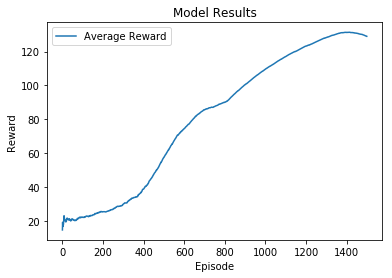

In [16]:
def main():
    try:
        env = gym.make("CartPole-v0")
        input_dim = env.observation_space.shape[0]
        output_dim = env.action_space.n
        sumReward = 0
        rewardStore = []
        avgRewardStore = []

        #Instantiate the agent
        agent = Agent(input_dim, output_dim, [16, 16])

        #Run 1500 times - originally at 2000 but results in overfitting
        for episode in range(1500):
            reward = run_episode(env, agent)
            rewardStore.append(reward)
            sumReward += reward
            avgReward = sumReward/(episode + 1)
            avgRewardStore.append(avgReward)
            print("Episode:",(episode + 1), "Reward:", reward, "Average Reward: ", avgReward)

        plotResults(avgRewardStore)
    
    finally:
        env.close()


if __name__ == '__main__':
    main()